# Serial Position Cell Analysis

Analyze TH data for serial positon cells. 

Cells of interest:
- 74 looks to be a serial position cell (not sure which session...)

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
from scipy.stats import sem
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from pynwb import NWBHDF5IO

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import (zscore_to_surrogates, compute_empirical_pvalue, 
                                           compute_surrogate_stats)
from spiketools.plts.space import plot_positions
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.data import plot_bar
from spiketools.plts.annotate import color_pval
from spiketools.utils import restrict_range, get_value_by_time, get_value_by_time_range, set_random_seed

In [3]:
import seaborn as sns
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions
from serial import compute_serial_position_fr

In [5]:
from functools import partial
from spiketools.stats.anova import create_dataframe, fit_anova
create_df_serial = partial(create_dataframe, columns=['segment', 'fr'])
fit_anova_serial = partial(fit_anova, formula='fr ~ C(segment)', feature='C(segment)')

# Settings

In [6]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [7]:
# Define the base data folder
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH/')
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [8]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 100

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {'shuffle_min' : 20000}

In [10]:
# Set example unit to analyze
uind = 74

# Load Data

In [11]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [12]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

#### Get Trial Data

In [13]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [14]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

#### Get Unit Data

In [15]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [16]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [17]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T

In [18]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# ANOVA Test

Use fr ~ C(segment), real data

## Single Trial

In [19]:
# Get trial information
t_ind = 10
#t_st = nwbfile.trials['start_time'][t_ind]
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [20]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [21]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [22]:
# Restrict spikes to the selected trial
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)
spike_positions = np.array([t_spike_xs, t_spike_ys])

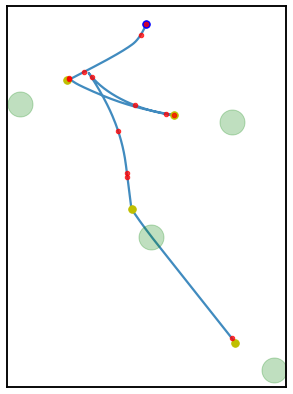

In [23]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
plot_positions(t_pos, alpha=0.85, figsize=(5, 7))
ax = plt.gca()
ax.plot(*t_pos[:, 0], 'b.', ms=15)
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.plot(t_spike_xs, t_spike_ys, '.r', alpha=0.75,)

In [24]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [25]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
frs = np.array(list(count.values())) / seg_times

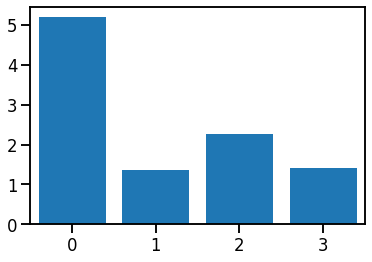

In [26]:
# Plot firing rate per segment (single trial)
plot_bar(frs, count.keys())

In [27]:
# Compute firing rates per segment for each trial
all_frs = compute_serial_position_fr(spikes, nav_starts, chest_openings, chest_trials, ptimes, positions)

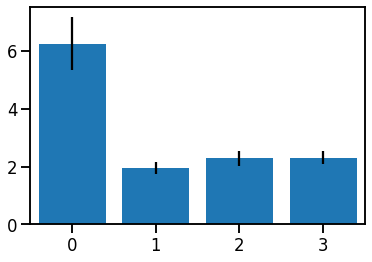

In [28]:
# Plot firing rates per segment across all trials
plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0))

In [29]:
# Create dataframe
df = create_df_serial(all_frs)

In [30]:
# Fit the ANOVA, and get f-value
f_val = fit_anova_serial(df)
f_val

16.750738855323217

## ANOVA Surrogate

In [31]:
# Create shuffled spike times
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [32]:
# Compute measures across shuffled time series for comparison
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    all_frs = compute_serial_position_fr(shuffle, nav_starts, chest_openings, 
                                         chest_trials, ptimes, positions)
    df = create_df_serial(all_frs)
    surrogates[ind] = fit_anova_serial(df)

p-value: 0.10
z-score: 1.19


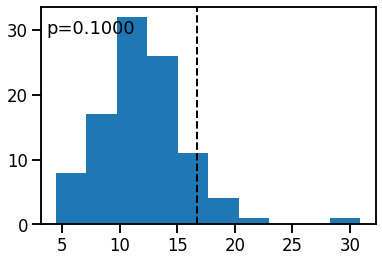

In [33]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(f_val, surrogates)

## All Cells

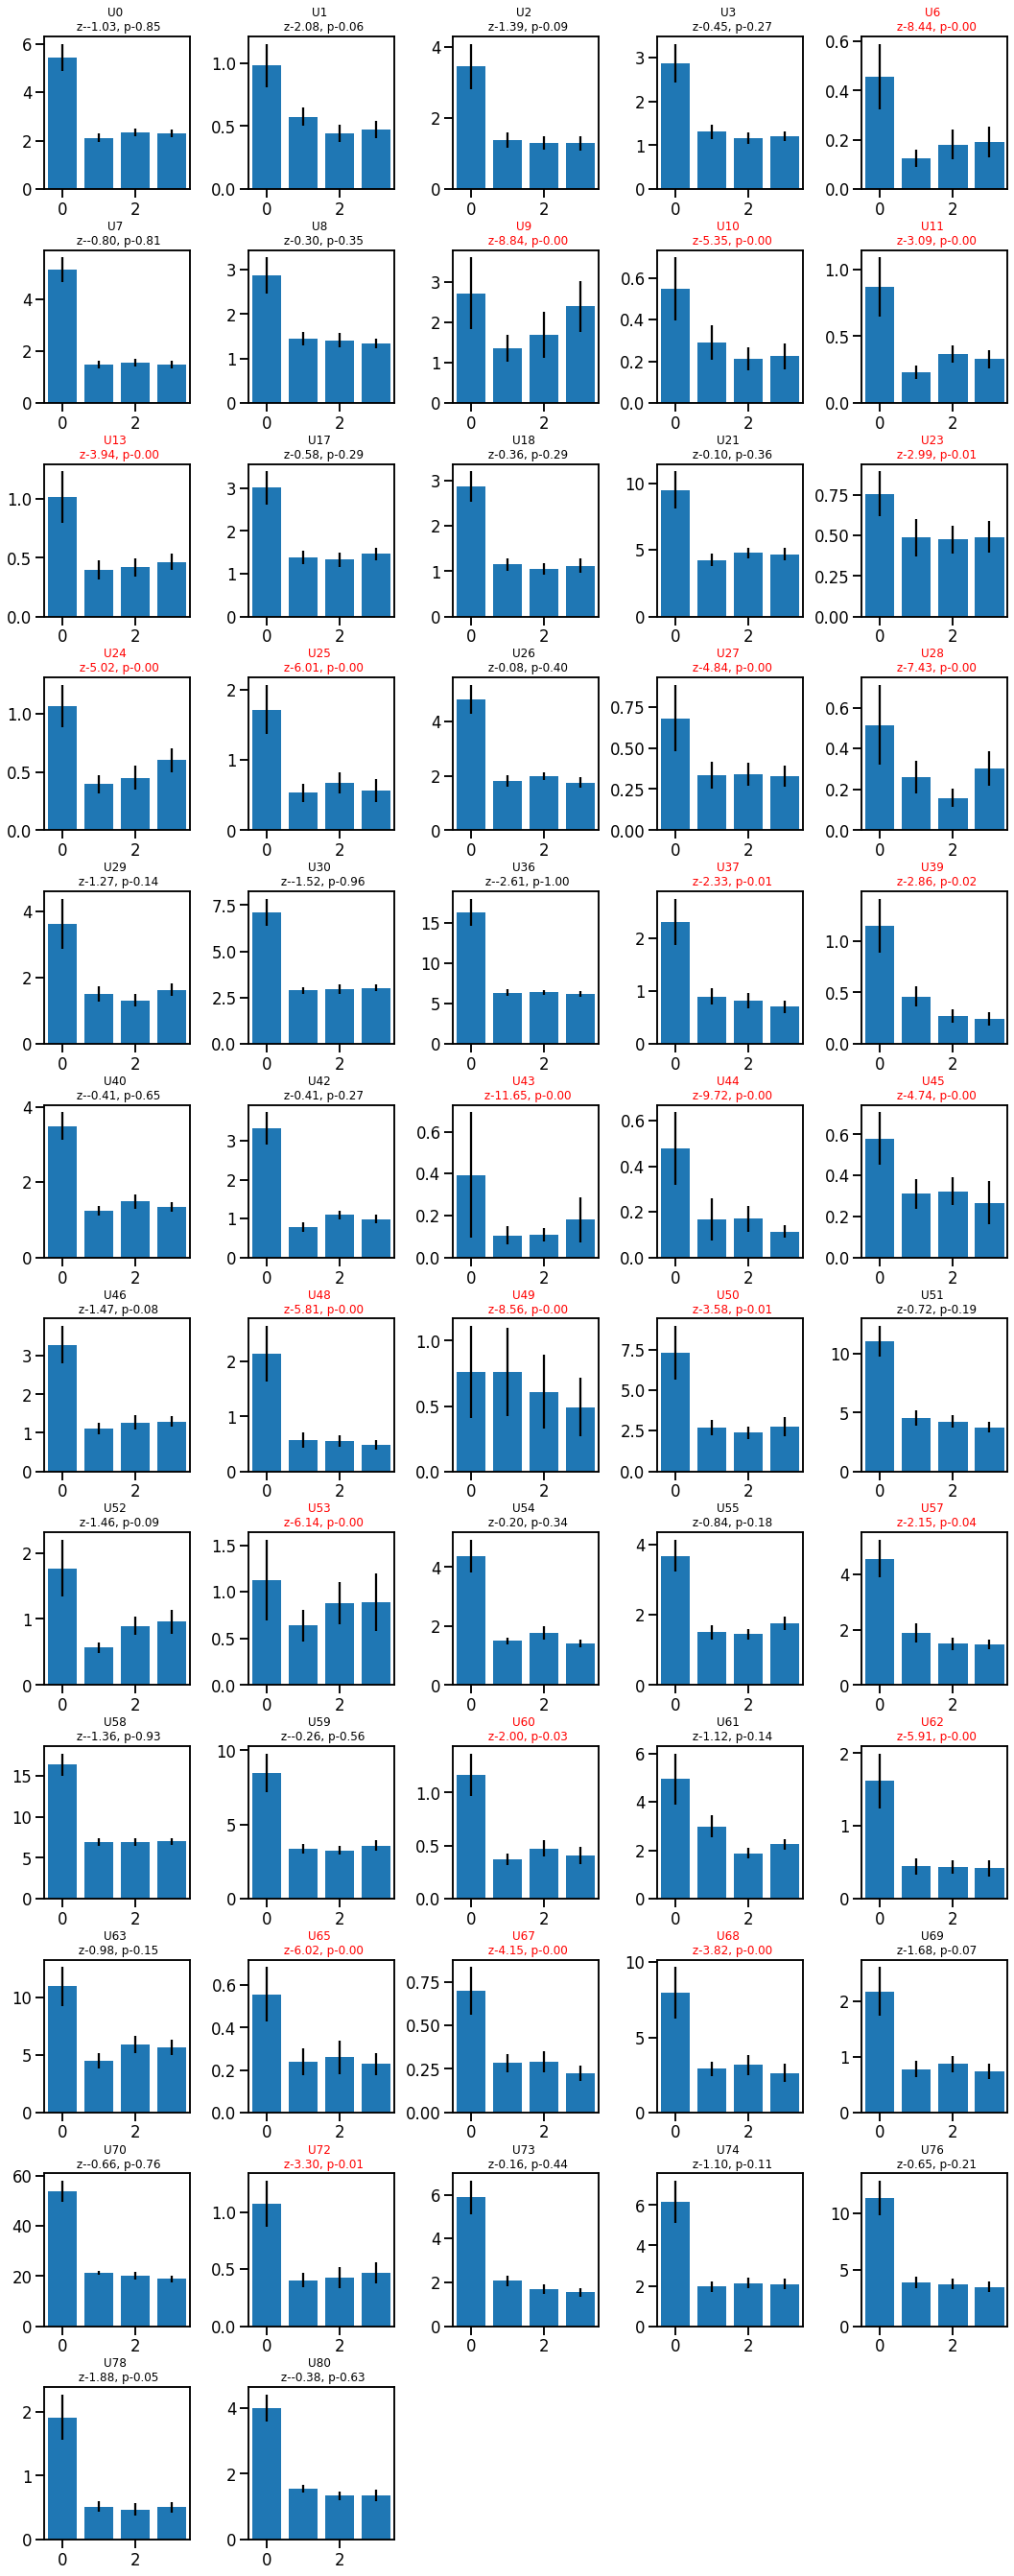

In [34]:
# Plot the firing rate per segment across trials for all units
for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):

    spikes = nwbfile.units.get_unit_spike_times(ii)    
    times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

    surrogates = np.zeros(n_surrogates)
    for ind, shuffle in enumerate(times_shuffle):
        all_frs = compute_serial_position_fr(shuffle, nav_starts, chest_openings, 
                                             chest_trials, ptimes, positions)
        df = create_df_serial(all_frs)
        surrogates[ind] = fit_anova_serial(df)
    
    p_val, z_score = compute_surrogate_stats(f_val, surrogates, plot=False, verbose=False)

    plot_bar(all_frs.mean(0), count.keys(), yerr=sem(all_frs, 0), ax=ax)
    ax.set_title('U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, p_val),
                 fontdict={'fontsize' : 12}, color=color_pval(p_val))